In [1]:
# Cell 1: Install required packages
!pip install kagglehub ultralytics opencv-python-headless tensorflow tensorflow-datasets -q
!pip install roboflow -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 21.7 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.8/91.8 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 39.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 58.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 33.5 MB/s eta 0:00:0000:01:00:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-adk 1.22.1 requires google-cloud-bigquery-storage>=2.0.0, which is not installed.
bigframes 2.26.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
google-colab 1.0.0 requires google-auth==2.38.0, but you have google-auth 2.47.0 which is incompatible.
google-colab 1.0.0 requires jupyter-ser

In [2]:
# Cell 2: Import libraries
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import shutil
import yaml

import kagglehub
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

from ultralytics import YOLO
from IPython.display import Image, display
import json

print("TensorFlow version:", tf.__version__)
print("GPU Available:", tf.config.list_physical_devices('GPU'))

2026-02-08 06:14:46.343325: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1770531286.763595      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1770531286.903946      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1770531287.790934      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770531287.790996      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770531287.791000      55 computation_placer.cc:177] computation placer alr

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
TensorFlow version: 2.19.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


In [3]:
# Cell 3: Download the license plate dataset from Kaggle
print("Downloading license plate dataset...")
dataset_path = kagglehub.dataset_download("fareselmenshawii/large-license-plate-dataset")
print(f"Dataset downloaded to: {dataset_path}")

# List the dataset structure
for root, dirs, files in os.walk(dataset_path):
    level = root.replace(dataset_path, '').count(os.sep)
    indent = ' ' * 2 * level
    print(f'{indent}{os.path.basename(root)}/')
    if level < 2:  # Only show first 2 levels
        subindent = ' ' * 2 * (level + 1)
        for file in files[:5]:  # Show first 5 files
            print(f'{subindent}{file}')
        if len(files) > 5:
            print(f'{subindent}... and {len(files) - 5} more files')

Dataset downloaded to: /kaggle/input/large-license-plate-dataset
large-license-plate-dataset/
  labels/
    val.cache
    train.cache
    val/
    test/
    train/
  images/
    val/
    test/
    train/


In [4]:
# Cell 4: Prepare dataset structure for YOLO training
# Create working directory
work_dir = '/kaggle/working/license_plate_project'
os.makedirs(work_dir, exist_ok=True)

# Define paths
images_dir = os.path.join(work_dir, 'images')
labels_dir = os.path.join(work_dir, 'labels')

# Create directory structure
for split in ['train', 'val', 'test']:
    os.makedirs(os.path.join(images_dir, split), exist_ok=True)
    os.makedirs(os.path.join(labels_dir, split), exist_ok=True)

print("Directory structure created!")

Directory structure created!


In [5]:
# Cell 5: Copy dataset to working directory
def copy_dataset(source_path, dest_path):
    """Copy dataset from source to destination"""
    for split in ['train', 'val', 'test']:
        # Copy images
        src_img_dir = os.path.join(source_path, 'images', split)
        dst_img_dir = os.path.join(dest_path, 'images', split)
        
        # Copy labels
        src_lbl_dir = os.path.join(source_path, 'labels', split)
        dst_lbl_dir = os.path.join(dest_path, 'labels', split)
        
        if os.path.exists(src_img_dir):
            for img_file in os.listdir(src_img_dir):
                shutil.copy(
                    os.path.join(src_img_dir, img_file),
                    os.path.join(dst_img_dir, img_file)
                )
        
        if os.path.exists(src_lbl_dir):
            for lbl_file in os.listdir(src_lbl_dir):
                shutil.copy(
                    os.path.join(src_lbl_dir, lbl_file),
                    os.path.join(dst_lbl_dir, lbl_file)
                )
        
        print(f"Copied {split} split - Images: {len(os.listdir(dst_img_dir))}, Labels: {len(os.listdir(dst_lbl_dir))}")

copy_dataset(dataset_path, work_dir)

Copied train split - Images: 25470, Labels: 25470
Copied val split - Images: 1073, Labels: 1073
Copied test split - Images: 386, Labels: 386


In [6]:
# Cell 6: Create YOLO configuration file
data_yaml = {
    'path': work_dir,
    'train': 'images/train',
    'val': 'images/val',
    'test': 'images/test',
    'nc': 1,  # number of classes (license plate)
    'names': ['license_plate']
}

yaml_path = os.path.join(work_dir, 'data.yaml')
with open(yaml_path, 'w') as f:
    yaml.dump(data_yaml, f)

print("YAML configuration created!")
print("\nContent:")
with open(yaml_path, 'r') as f:
    print(f.read())

YAML configuration created!

Content:
names:
- license_plate
nc: 1
path: /kaggle/working/license_plate_project
test: images/test
train: images/train
val: images/val



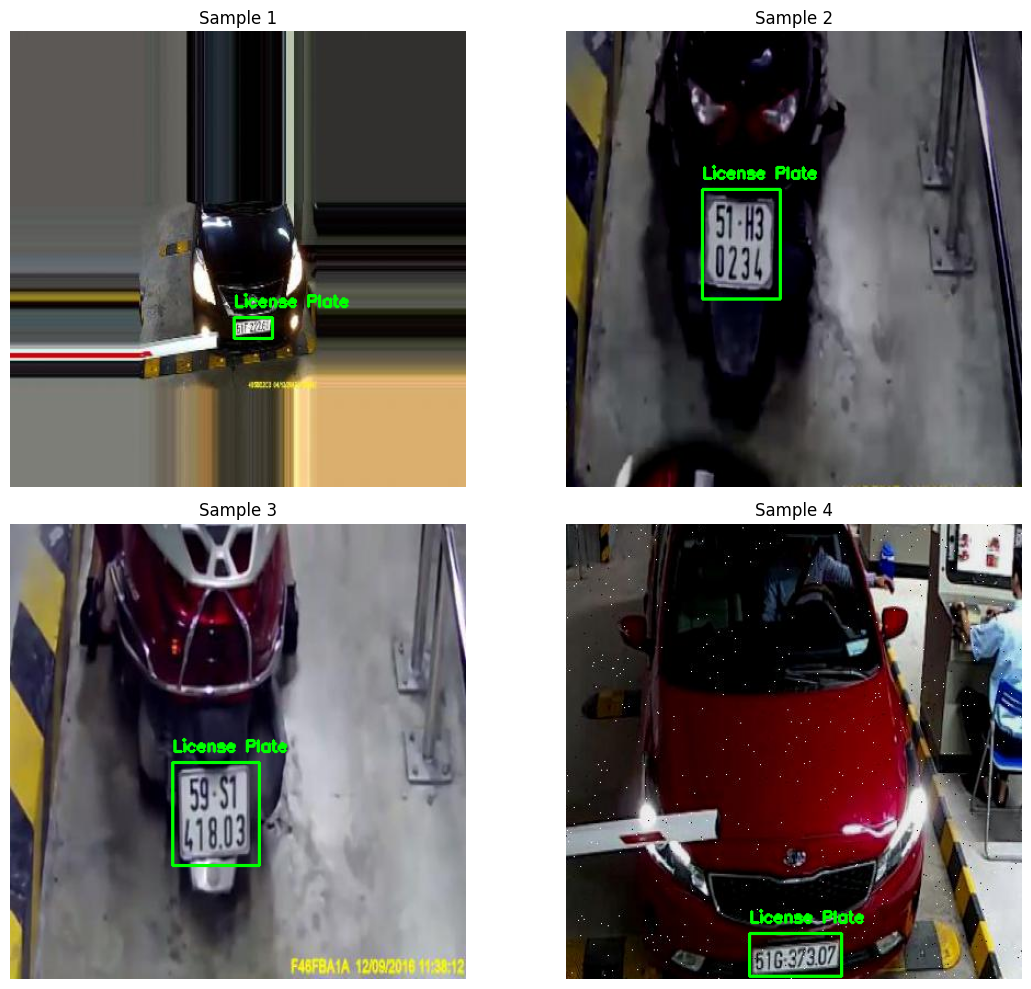

In [7]:
# Cell 7: Visualize sample images with bounding boxes
def visualize_samples(images_dir, labels_dir, num_samples=4):
    """Visualize sample images with their bounding boxes"""
    img_files = os.listdir(os.path.join(images_dir, 'train'))[:num_samples]
    
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    axes = axes.ravel()
    
    for idx, img_file in enumerate(img_files):
        # Read image
        img_path = os.path.join(images_dir, 'train', img_file)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        h, w = img.shape[:2]
        
        # Read label
        label_file = img_file.replace('.jpg', '.txt').replace('.png', '.txt')
        label_path = os.path.join(labels_dir, 'train', label_file)
        
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                for line in f:
                    # Parse YOLO format: class x_center y_center width height
                    parts = line.strip().split()
                    if len(parts) >= 5:
                        cls, x_center, y_center, width, height = map(float, parts[:5])
                        
                        # Convert to pixel coordinates
                        x_center *= w
                        y_center *= h
                        width *= w
                        height *= h
                        
                        # Calculate box corners
                        x1 = int(x_center - width / 2)
                        y1 = int(y_center - height / 2)
                        x2 = int(x_center + width / 2)
                        y2 = int(y_center + height / 2)
                        
                        # Draw rectangle
                        cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
                        cv2.putText(img, 'License Plate', (x1, y1-10), 
                                  cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
        
        axes[idx].imshow(img)
        axes[idx].set_title(f'Sample {idx+1}')
        axes[idx].axis('off')
    
    plt.tight_layout()
    plt.show()

visualize_samples(images_dir, labels_dir)

In [8]:
# Cell 8: Initialize and train YOLOv8 model for license plate detection
print("Loading YOLOv8 model...")
model = YOLO('yolov8n.pt')  # Load pretrained YOLOv8 nano model

print("\nStarting training...")
# Train the model
results = model.train(
    data=yaml_path,
    epochs=50,  # Adjust based on your needs
    imgsz=416,  # Image size (as per paper)
    batch=16,  # Adjust based on your GPU memory
    lr0=0.001,  # Learning rate (as per paper)
    name='license_plate_detector',
    patience=10,  # Early stopping patience
    save=True,
    plots=True
)

print("\nTraining completed!")

Loading YOLOv8 model...

Starting training...
Ultralytics 8.4.12 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 14913MiB)
engine/trainer: agnostic_nms=False, amp=True, angle=1.0, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/license_plate_project/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, end2end=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=416, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=0.0, name=license_plate_detector, nbs=64, nms=False, opset=N

In [9]:
# Cell 9: Evaluate the trained model
print("Evaluating model on validation set...")
metrics = model.val()

print(f"\nValidation Results:")
print(f"mAP50: {metrics.box.map50:.4f}")
print(f"mAP50-95: {metrics.box.map:.4f}")
print(f"Precision: {metrics.box.mp:.4f}")
print(f"Recall: {metrics.box.mr:.4f}")

Evaluating model on validation set...
Ultralytics 8.4.12 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 14913MiB)
Model summary (fused): 73 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2875.8±1013.2 MB/s, size: 270.3 KB)
val: Scanning /kaggle/working/license_plate_project/labels/val.cache... 1073 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 1073/1073 450.0Mit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 68/68 11.2it/s 6.1s0.2s
                   all       1073       1573      0.855      0.739      0.789       0.41
Speed: 0.3ms preprocess, 1.9ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to /kaggle/working/runs/detect/val

Validation Results:
mAP50: 0.7886
mAP50-95: 0.4104
Precision: 0.8546
Recall: 0.7387



image 1/1 /kaggle/working/license_plate_project/images/test/f83d18919353c483.jpg: 288x416 1 license_plate, 38.2ms
Speed: 1.6ms preprocess, 38.2ms inference, 1.5ms postprocess per image at shape (1, 3, 288, 416)

image 1/1 /kaggle/working/license_plate_project/images/test/724307be418b2ed2.jpg: 320x416 1 license_plate, 37.9ms
Speed: 1.5ms preprocess, 37.9ms inference, 1.1ms postprocess per image at shape (1, 3, 320, 416)

image 1/1 /kaggle/working/license_plate_project/images/test/88df55ff4e13b90d.jpg: 320x416 1 license_plate, 5.7ms
Speed: 1.1ms preprocess, 5.7ms inference, 1.1ms postprocess per image at shape (1, 3, 320, 416)

image 1/1 /kaggle/working/license_plate_project/images/test/70e7b5173fe1e289.jpg: 320x416 1 license_plate, 5.6ms
Speed: 1.2ms preprocess, 5.6ms inference, 1.1ms postprocess per image at shape (1, 3, 320, 416)


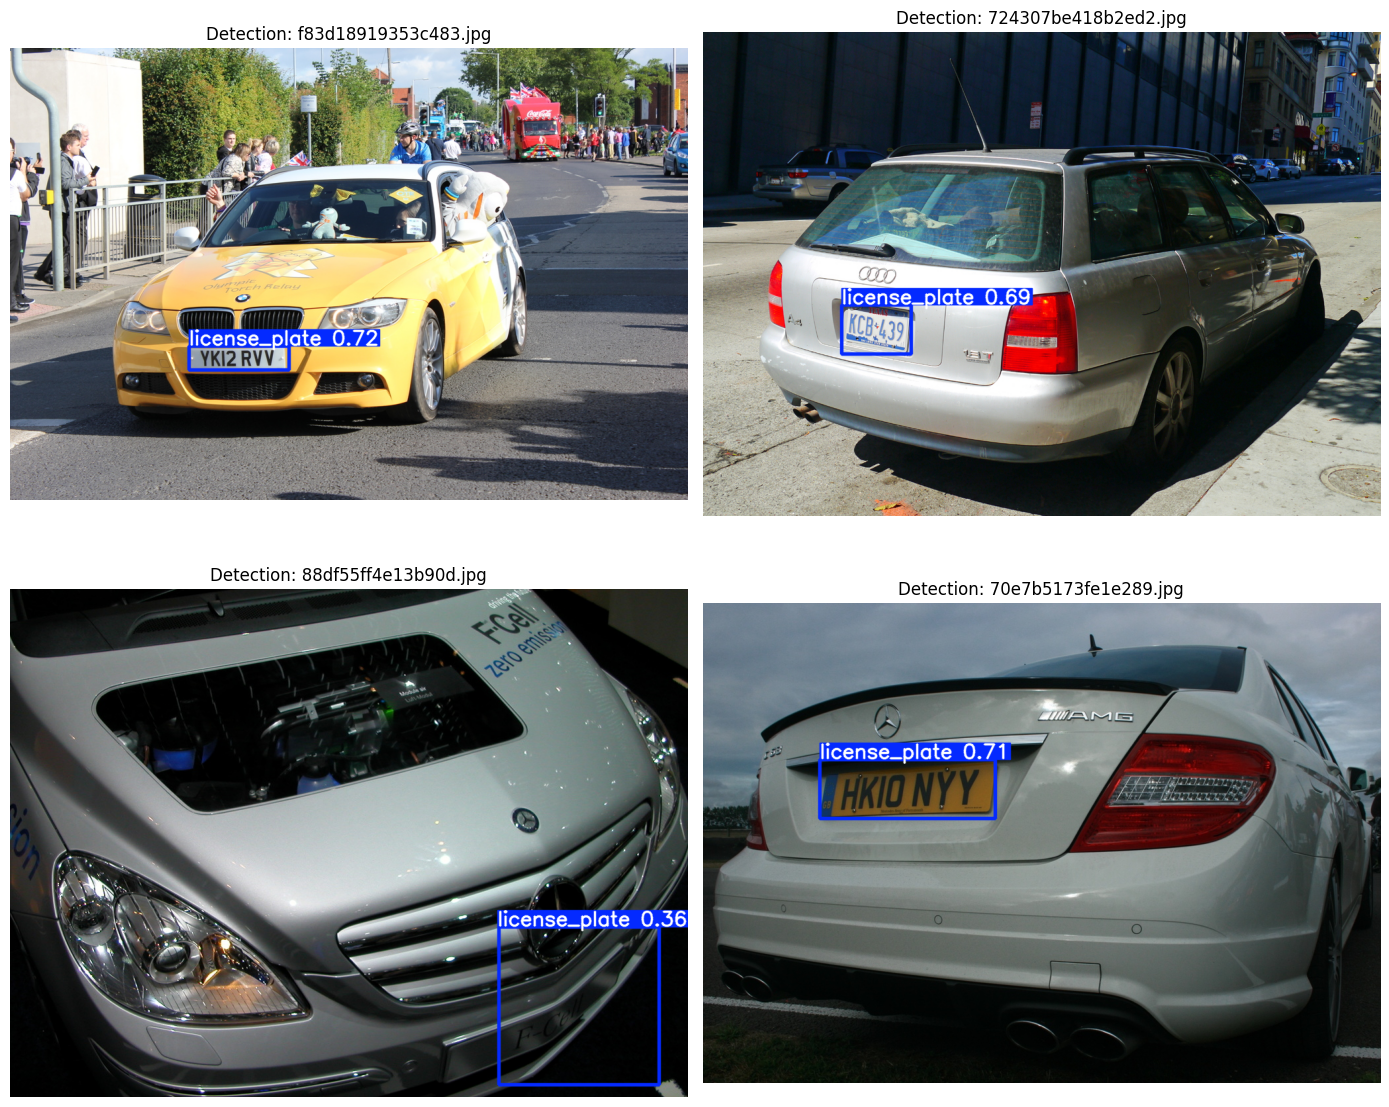

In [10]:
# Cell 10: Test detection on sample images
def test_detection(model, test_images_dir, num_samples=4):
    """Test license plate detection on sample images"""
    test_imgs = os.listdir(test_images_dir)[:num_samples]
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 12))
    axes = axes.ravel()
    
    for idx, img_file in enumerate(test_imgs):
        img_path = os.path.join(test_images_dir, img_file)
        
        # Predict
        results = model(img_path)
        
        # Plot
        result_img = results[0].plot()
        result_img = cv2.cvtColor(result_img, cv2.COLOR_BGR2RGB)
        
        axes[idx].imshow(result_img)
        axes[idx].set_title(f'Detection: {img_file}')
        axes[idx].axis('off')
    
    plt.tight_layout()
    plt.show()

test_imgs_dir = os.path.join(images_dir, 'test')
test_detection(model, test_imgs_dir)

In [11]:
# Cell 11: Save the trained YOLO model
model_save_path = os.path.join(work_dir, 'best_license_plate_detector.pt')
shutil.copy(
    'runs/detect/license_plate_detector/weights/best.pt',
    model_save_path
)
print(f"Model saved to: {model_save_path}")

Model saved to: /kaggle/working/license_plate_project/best_license_plate_detector.pt


In [12]:
# Cell 12: STEP 2 - Load and prepare EMNIST dataset for character recognition
print("Loading EMNIST dataset...")

# Load EMNIST Balanced dataset (includes digits and letters)
(ds_train, ds_test), ds_info = tfds.load(
    'emnist/balanced',
    split=['train', 'test'],
    as_supervised=True,
    with_info=True
)

print(f"\nDataset info:")
print(f"Number of classes: {ds_info.features['label'].num_classes}")
print(f"Training samples: {ds_info.splits['train'].num_examples}")
print(f"Test samples: {ds_info.splits['test'].num_examples}")

# Get class names
class_names = ds_info.features['label'].names
print(f"\nClasses: {class_names[:10]}... (showing first 10)")

Loading EMNIST dataset...


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

I0000 00:00:1770541921.405138      55 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 12783 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1770541921.410300      55 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13757 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Shuffling /root/tensorflow_datasets/emnist/balanced/incomplete.GQ8JTG_3.1.0/emnist-train.tfrecord*...:   0%|  …

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/emnist/balanced/incomplete.GQ8JTG_3.1.0/emnist-test.tfrecord*...:   0%|   …

Dataset emnist downloaded and prepared to /root/tensorflow_datasets/emnist/balanced/3.1.0. Subsequent calls will reuse this data.

Dataset info:
Number of classes: 47
Training samples: 112800
Test samples: 18800

Classes: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']... (showing first 10)


In [13]:
# Cell 13: Preprocess EMNIST data
def preprocess_emnist(image, label):
    """Preprocess EMNIST images"""
    # Normalize pixel values to [0, 1]
    image = tf.cast(image, tf.float32) / 255.0
    
    # Resize to a standard size
    image = tf.image.resize(image, [32, 32])
    
    # EMNIST images need rotation and flip
    image = tf.image.rot90(image, k=3)
    image = tf.image.flip_left_right(image)
    
    return image, label

# Apply preprocessing
BATCH_SIZE = 64
AUTOTUNE = tf.data.AUTOTUNE

ds_train_processed = (
    ds_train
    .map(preprocess_emnist, num_parallel_calls=AUTOTUNE)
    .cache()
    .shuffle(10000)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

ds_test_processed = (
    ds_test
    .map(preprocess_emnist, num_parallel_calls=AUTOTUNE)
    .batch(BATCH_SIZE)
    .cache()
    .prefetch(AUTOTUNE)
)

print("EMNIST dataset preprocessed!")

EMNIST dataset preprocessed!


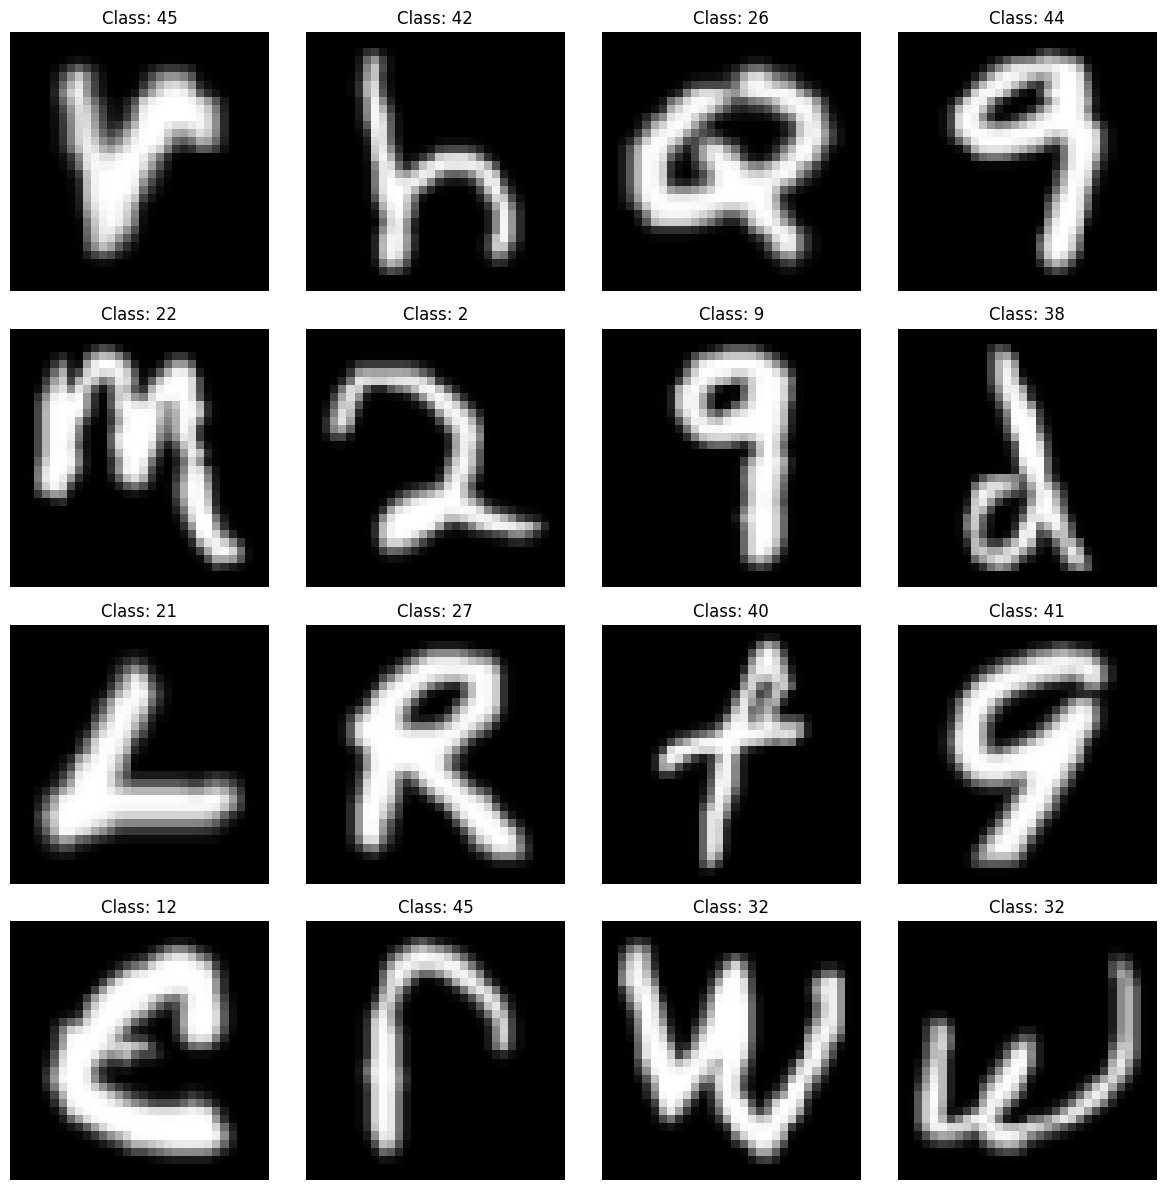

In [14]:
# Cell 14: Visualize EMNIST samples
def visualize_emnist_samples(dataset, class_names, num_samples=16):
    """Visualize EMNIST samples"""
    plt.figure(figsize=(12, 12))
    
    for images, labels in dataset.take(1):
        for i in range(min(num_samples, len(images))):
            plt.subplot(4, 4, i + 1)
            plt.imshow(images[i].numpy().squeeze(), cmap='gray')
            plt.title(f"Class: {class_names[labels[i]]}")
            plt.axis('off')
    
    plt.tight_layout()
    plt.show()

visualize_emnist_samples(ds_train_processed, class_names)

In [15]:
# Cell 15: Build CNN model for character recognition
def create_character_recognition_model(num_classes):
    """Create CNN model for character recognition"""
    model = keras.Sequential([
        # Input layer
        layers.Input(shape=(32, 32, 1)),
        
        # First conv block
        layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        # Second conv block
        layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        # Third conv block
        layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        # Dense layers
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        
        # Output layer
        layers.Dense(num_classes, activation='softmax')
    ])
    
    return model

# Create model
num_classes = ds_info.features['label'].num_classes
char_model = create_character_recognition_model(num_classes)

# Compile model
char_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

char_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 8, 8, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 853,263 (3.25 MB)

 Trainable params: 851,599 (3.25 MB)

 Non-trainable params: 1,664 (6.50 KB)

In [16]:
# Cell 16: Train character recognition model
print("Training character recognition model...")

# Callbacks
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-7
    ),
    keras.callbacks.ModelCheckpoint(
        os.path.join(work_dir, 'best_char_recognition_model.h5'),
        monitor='val_accuracy',
        save_best_only=True
    )
]

# Train
history = char_model.fit(
    ds_train_processed,
    validation_data=ds_test_processed,
    epochs=20,
    callbacks=callbacks,
    verbose=1
)

print("\nCharacter recognition model training completed!")

Training character recognition model...
Epoch 1/20


I0000 00:00:1770542049.001277     292 service.cc:152] XLA service 0x78820c2575b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1770542049.001317     292 service.cc:160]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1770542049.001322     292 service.cc:160]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1770542050.030851     292 cuda_dnn.cc:529] Loaded cuDNN version 91002


  13/1763 ━━━━━━━━━━━━━━━━━━━━ 24s 14ms/step - accuracy: 0.0228 - loss: 4.9124

I0000 00:00:1770542057.768550     292 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1763/1763 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5140 - loss: 1.8148

1763/1763 ━━━━━━━━━━━━━━━━━━━━ 41s 16ms/step - accuracy: 0.5141 - loss: 1.8144 - val_accuracy: 0.8564 - val_loss: 0.4253 - learning_rate: 0.0010
Epoch 2/20
1760/1763 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8151 - loss: 0.5517

1763/1763 ━━━━━━━━━━━━━━━━━━━━ 16s 9ms/step - accuracy: 0.8151 - loss: 0.5516 - val_accuracy: 0.8589 - val_loss: 0.3885 - learning_rate: 0.0010
Epoch 3/20
1759/1763 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8398 - loss: 0.4739

1763/1763 ━━━━━━━━━━━━━━━━━━━━ 16s 9ms/step - accuracy: 0.8398 - loss: 0.4739 - val_accuracy: 0.8781 - val_loss: 0.3445 - learning_rate: 0.0010
Epoch 4/20
1757/1763 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8538 - loss: 0.4251

1763/1763 ━━━━━━━━━━━━━━━━━━━━ 16s 9ms/step - accuracy: 0.8538 - loss: 0.4251 - val_accuracy: 0.8838 - val_loss: 0.3276 - learning_rate: 0.0010
Epoch 5/20
1758/1763 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8627 - loss: 0.3981

1763/1763 ━━━━━━━━━━━━━━━━━━━━ 16s 9ms/step - accuracy: 0.8627 - loss: 0.3980 - val_accuracy: 0.8895 - val_loss: 0.3172 - learning_rate: 0.0010
Epoch 6/20
1761/1763 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8693 - loss: 0.3755

1763/1763 ━━━━━━━━━━━━━━━━━━━━ 16s 9ms/step - accuracy: 0.8693 - loss: 0.3755 - val_accuracy: 0.8920 - val_loss: 0.3069 - learning_rate: 0.0010
Epoch 7/20
1763/1763 ━━━━━━━━━━━━━━━━━━━━ 16s 9ms/step - accuracy: 0.8728 - loss: 0.3596 - val_accuracy: 0.8915 - val_loss: 0.3046 - learning_rate: 0.0010
Epoch 8/20
1762/1763 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8758 - loss: 0.3502

1763/1763 ━━━━━━━━━━━━━━━━━━━━ 16s 9ms/step - accuracy: 0.8758 - loss: 0.3502 - val_accuracy: 0.8929 - val_loss: 0.3008 - learning_rate: 0.0010
Epoch 9/20
1758/1763 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8808 - loss: 0.3327

1763/1763 ━━━━━━━━━━━━━━━━━━━━ 16s 9ms/step - accuracy: 0.8808 - loss: 0.3327 - val_accuracy: 0.8952 - val_loss: 0.3006 - learning_rate: 0.0010
Epoch 10/20
1758/1763 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8841 - loss: 0.3236

1763/1763 ━━━━━━━━━━━━━━━━━━━━ 16s 9ms/step - accuracy: 0.8841 - loss: 0.3236 - val_accuracy: 0.8953 - val_loss: 0.2972 - learning_rate: 0.0010
Epoch 11/20
1760/1763 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8866 - loss: 0.3150

1763/1763 ━━━━━━━━━━━━━━━━━━━━ 16s 9ms/step - accuracy: 0.8866 - loss: 0.3150 - val_accuracy: 0.8997 - val_loss: 0.2916 - learning_rate: 0.0010
Epoch 12/20
1763/1763 ━━━━━━━━━━━━━━━━━━━━ 16s 9ms/step - accuracy: 0.8880 - loss: 0.3114 - val_accuracy: 0.8963 - val_loss: 0.2939 - learning_rate: 0.0010
Epoch 13/20
1763/1763 ━━━━━━━━━━━━━━━━━━━━ 16s 9ms/step - accuracy: 0.8908 - loss: 0.3043 - val_accuracy: 0.8970 - val_loss: 0.2966 - learning_rate: 0.0010
Epoch 14/20
1763/1763 ━━━━━━━━━━━━━━━━━━━━ 16s 9ms/step - accuracy: 0.8924 - loss: 0.2965 - val_accuracy: 0.8996 - val_loss: 0.2852 - learning_rate: 0.0010
Epoch 15/20
1763/1763 ━━━━━━━━━━━━━━━━━━━━ 16s 9ms/step - accuracy: 0.8944 - loss: 0.2910 - val_accuracy: 0.8987 - val_loss: 0.2924 - learning_rate: 0.0010
Epoch 16/20
1759/1763 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8935 - loss: 0.2899

1763/1763 ━━━━━━━━━━━━━━━━━━━━ 16s 9ms/step - accuracy: 0.8935 - loss: 0.2899 - val_accuracy: 0.9011 - val_loss: 0.2898 - learning_rate: 0.0010
Epoch 17/20
1763/1763 ━━━━━━━━━━━━━━━━━━━━ 16s 9ms/step - accuracy: 0.8968 - loss: 0.2847 - val_accuracy: 0.8994 - val_loss: 0.2897 - learning_rate: 0.0010
Epoch 18/20
1760/1763 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9028 - loss: 0.2671

1763/1763 ━━━━━━━━━━━━━━━━━━━━ 16s 9ms/step - accuracy: 0.9028 - loss: 0.2671 - val_accuracy: 0.9033 - val_loss: 0.2814 - learning_rate: 5.0000e-04
Epoch 19/20
1763/1763 ━━━━━━━━━━━━━━━━━━━━ 16s 9ms/step - accuracy: 0.9059 - loss: 0.2538 - val_accuracy: 0.9028 - val_loss: 0.2878 - learning_rate: 5.0000e-04
Epoch 20/20
1763/1763 ━━━━━━━━━━━━━━━━━━━━ 16s 9ms/step - accuracy: 0.9067 - loss: 0.2482 - val_accuracy: 0.9021 - val_loss: 0.2888 - learning_rate: 5.0000e-04

Character recognition model training completed!


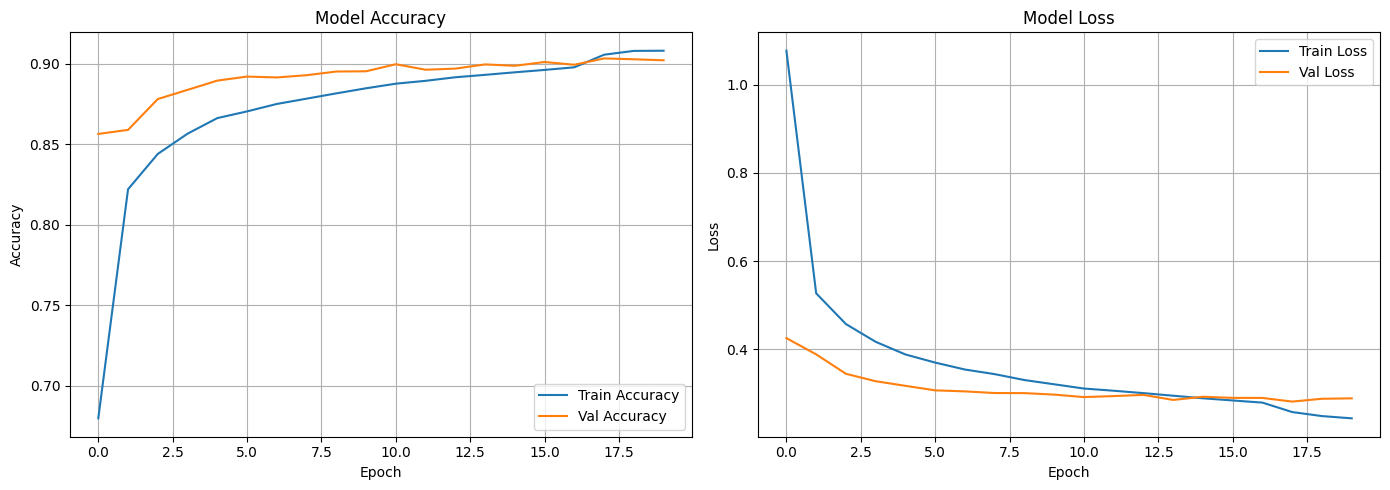

In [17]:
# Cell 17: Plot training history
def plot_training_history(history):
    """Plot training and validation metrics"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    # Accuracy
    ax1.plot(history.history['accuracy'], label='Train Accuracy')
    ax1.plot(history.history['val_accuracy'], label='Val Accuracy')
    ax1.set_title('Model Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(True)
    
    # Loss
    ax2.plot(history.history['loss'], label='Train Loss')
    ax2.plot(history.history['val_loss'], label='Val Loss')
    ax2.set_title('Model Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()

plot_training_history(history)

In [18]:
# Cell 18: Evaluate character recognition model
print("Evaluating character recognition model...")
test_loss, test_accuracy = char_model.evaluate(ds_test_processed)
print(f"\nTest Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

Evaluating character recognition model...
294/294 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9060 - loss: 0.2733

Test Accuracy: 0.9033
Test Loss: 0.2814


In [19]:
# Cell 19: Helper functions for end-to-end license plate recognition
def detect_license_plate(image_path, yolo_model):
    """Detect and crop license plate from image"""
    results = yolo_model(image_path)
    
    # Get the image
    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    cropped_plates = []
    boxes = []
    
    for result in results:
        if result.boxes is not None and len(result.boxes) > 0:
            for box in result.boxes:
                # Get box coordinates
                x1, y1, x2, y2 = map(int, box.xyxy[0])
                confidence = float(box.conf[0])
                
                if confidence > 0.5:  # Confidence threshold
                    # Crop license plate
                    plate_img = img_rgb[y1:y2, x1:x2]
                    cropped_plates.append(plate_img)
                    boxes.append((x1, y1, x2, y2, confidence))
    
    return img_rgb, cropped_plates, boxes

def preprocess_plate_for_ocr(plate_img):
    """Preprocess license plate image for character recognition"""
    # Convert to grayscale
    gray = cv2.cvtColor(plate_img, cv2.COLOR_RGB2GRAY)
    
    # Apply thresholding
    _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    # Denoise
    denoised = cv2.fastNlMeansDenoising(thresh)
    
    return denoised

def segment_characters(plate_img):
    """Segment individual characters from license plate"""
    # Preprocess
    processed = preprocess_plate_for_ocr(plate_img)
    
    # Find contours
    contours, _ = cv2.findContours(
        processed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
    )
    
    # Filter and sort contours
    char_contours = []
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        aspect_ratio = h / w if w > 0 else 0
        area = w * h
        
        # Filter based on aspect ratio and area
        if 0.5 < aspect_ratio < 3.5 and area > 100:
            char_contours.append((x, y, w, h))
    
    # Sort by x-coordinate (left to right)
    char_contours = sorted(char_contours, key=lambda c: c[0])
    
    # Extract character images
    char_images = []
    for (x, y, w, h) in char_contours:
        char_img = processed[y:y+h, x:x+w]
        
        # Resize to 32x32 for model input
        char_img_resized = cv2.resize(char_img, (32, 32))
        
        # Normalize and reshape
        char_img_normalized = char_img_resized.astype('float32') / 255.0
        char_img_normalized = np.expand_dims(char_img_normalized, axis=-1)
        
        char_images.append(char_img_normalized)
    
    return char_images, char_contours

def recognize_characters(char_images, model, class_names):
    """Recognize characters using trained CNN model"""
    if len(char_images) == 0:
        return ""
    
    # Stack images
    char_batch = np.array(char_images)
    
    # Predict
    predictions = model.predict(char_batch, verbose=0)
    predicted_classes = np.argmax(predictions, axis=1)
    
    # Convert to string
    recognized_text = ''.join([class_names[idx] for idx in predicted_classes])
    
    return recognized_text

print("Helper functions defined!")

Helper functions defined!


In [20]:
# Cell 20: Complete end-to-end license plate recognition pipeline
def recognize_license_plate(image_path, yolo_model, char_model, class_names):
    """Complete pipeline for license plate recognition"""
    # Step 1: Detect license plate
    original_img, cropped_plates, boxes = detect_license_plate(image_path, yolo_model)
    
    if len(cropped_plates) == 0:
        print("No license plate detected!")
        return None, None, None
    
    results = []
    
    for idx, plate_img in enumerate(cropped_plates):
        # Step 2: Segment characters
        char_images, char_contours = segment_characters(plate_img)
        
        if len(char_images) == 0:
            recognized_text = "Could not segment characters"
        else:
            # Step 3: Recognize characters
            recognized_text = recognize_characters(char_images, char_model, class_names)
        
        results.append({
            'plate_image': plate_img,
            'recognized_text': recognized_text,
            'confidence': boxes[idx][4],
            'box': boxes[idx][:4]
        })
    
    return original_img, results, boxes

print("End-to-end pipeline ready!")

End-to-end pipeline ready!



Processing: f83d18919353c483.jpg

image 1/1 /kaggle/working/license_plate_project/images/test/f83d18919353c483.jpg: 288x416 1 license_plate, 8.3ms
Speed: 2.4ms preprocess, 8.3ms inference, 1.7ms postprocess per image at shape (1, 3, 288, 416)


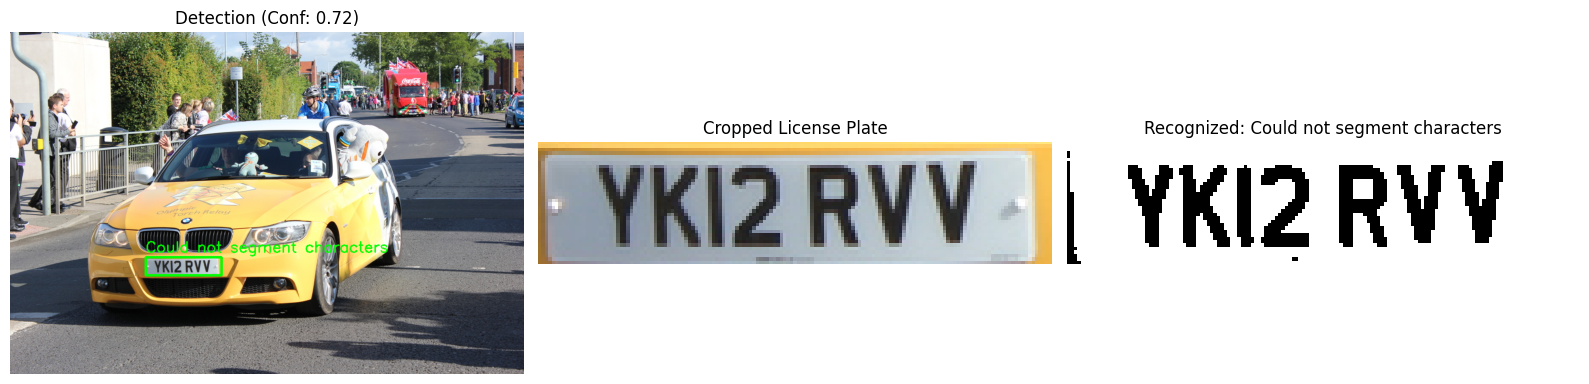


Processing: 724307be418b2ed2.jpg

image 1/1 /kaggle/working/license_plate_project/images/test/724307be418b2ed2.jpg: 320x416 1 license_plate, 6.7ms
Speed: 1.2ms preprocess, 6.7ms inference, 1.3ms postprocess per image at shape (1, 3, 320, 416)


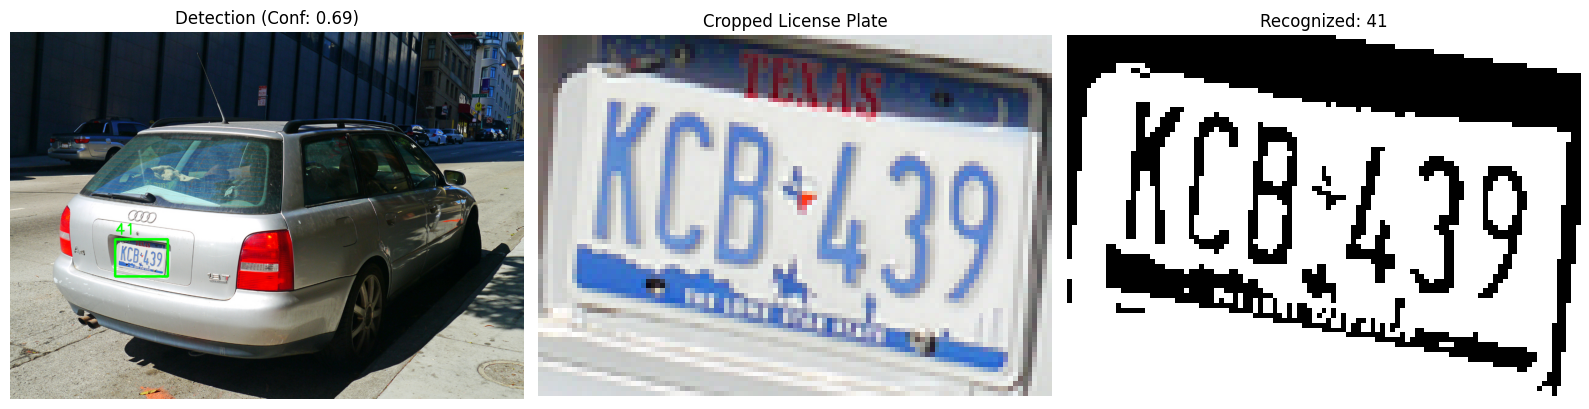


Processing: 88df55ff4e13b90d.jpg

image 1/1 /kaggle/working/license_plate_project/images/test/88df55ff4e13b90d.jpg: 320x416 1 license_plate, 6.0ms
Speed: 1.3ms preprocess, 6.0ms inference, 1.3ms postprocess per image at shape (1, 3, 320, 416)
No license plate detected!


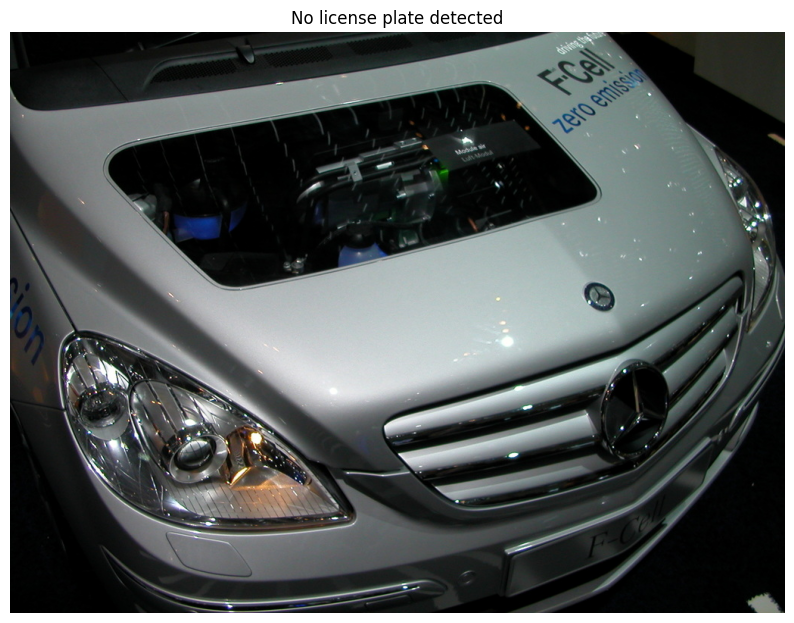

In [21]:
# Cell 21: Test the complete system on sample images
def visualize_recognition_results(image_path, yolo_model, char_model, class_names):
    """Visualize complete recognition results"""
    original_img, results, boxes = recognize_license_plate(
        image_path, yolo_model, char_model, class_names
    )
    
    if results is None:
        plt.figure(figsize=(10, 8))
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(img)
        plt.title("No license plate detected")
        plt.axis('off')
        plt.show()
        return
    
    num_plates = len(results)
    fig = plt.figure(figsize=(16, 6 * num_plates))
    
    for idx, result in enumerate(results):
        # Plot original image with detection
        ax1 = plt.subplot(num_plates, 3, idx * 3 + 1)
        img_with_box = original_img.copy()
        x1, y1, x2, y2 = result['box']
        cv2.rectangle(img_with_box, (x1, y1), (x2, y2), (0, 255, 0), 3)
        cv2.putText(
            img_with_box, 
            f"{result['recognized_text']}", 
            (x1, y1 - 10),
            cv2.FONT_HERSHEY_SIMPLEX, 
            1, 
            (0, 255, 0), 
            2
        )
        ax1.imshow(img_with_box)
        ax1.set_title(f"Detection (Conf: {result['confidence']:.2f})")
        ax1.axis('off')
        
        # Plot cropped plate
        ax2 = plt.subplot(num_plates, 3, idx * 3 + 2)
        ax2.imshow(result['plate_image'])
        ax2.set_title("Cropped License Plate")
        ax2.axis('off')
        
        # Plot processed plate
        ax3 = plt.subplot(num_plates, 3, idx * 3 + 3)
        processed = preprocess_plate_for_ocr(result['plate_image'])
        ax3.imshow(processed, cmap='gray')
        ax3.set_title(f"Recognized: {result['recognized_text']}")
        ax3.axis('off')
    
    plt.tight_layout()
    plt.show()

# Test on sample images
test_images = [os.path.join(test_imgs_dir, f) for f in os.listdir(test_imgs_dir)[:3]]

for img_path in test_images:
    print(f"\n{'='*60}")
    print(f"Processing: {os.path.basename(img_path)}")
    print(f"{'='*60}")
    visualize_recognition_results(img_path, model, char_model, class_names)

In [22]:
# Cell 22: Calculate Character Recognition Rate (CRR) - as per paper
def calculate_crr(ground_truth, predicted):
    """Calculate Character Recognition Rate"""
    if len(ground_truth) == 0:
        return 0.0
    
    correct = sum(1 for gt, pred in zip(ground_truth, predicted) if gt == pred)
    crr = (correct / len(ground_truth)) * 100
    return crr

# Example usage (you would need ground truth labels for real evaluation)
print("Character Recognition Rate (CRR) calculation function ready!")
print("\nExample:")
ground_truth = "ABC1234"
predicted = "ABC1234"
crr = calculate_crr(ground_truth, predicted)
print(f"Ground Truth: {ground_truth}")
print(f"Predicted: {predicted}")
print(f"CRR: {crr:.2f}%")

Character Recognition Rate (CRR) calculation function ready!

Example:
Ground Truth: ABC1234
Predicted: ABC1234
CRR: 100.00%


In [23]:
# Cell 23: Save both models
# YOLO model is already saved
print(f"YOLO model saved at: {model_save_path}")

# Save character recognition model
char_model_path = os.path.join(work_dir, 'char_recognition_model_final.h5')
char_model.save(char_model_path)
print(f"Character recognition model saved at: {char_model_path}")

# Save class names
import pickle
class_names_path = os.path.join(work_dir, 'class_names.pkl')
with open(class_names_path, 'wb') as f:
    pickle.dump(class_names, f)
print(f"Class names saved at: {class_names_path}")

YOLO model saved at: /kaggle/working/license_plate_project/best_license_plate_detector.pt
Character recognition model saved at: /kaggle/working/license_plate_project/char_recognition_model_final.h5
Class names saved at: /kaggle/working/license_plate_project/class_names.pkl


In [24]:
# Cell 24: Create inference function for production use
def load_models(yolo_path, char_model_path, class_names_path):
    """Load both models for inference"""
    # Load YOLO model
    yolo_model = YOLO(yolo_path)
    
    # Load character recognition model
    char_model = keras.models.load_model(char_model_path)
    
    # Load class names
    import pickle
    with open(class_names_path, 'rb') as f:
        class_names = pickle.load(f)
    
    return yolo_model, char_model, class_names

def predict_license_plate(image_path, yolo_model, char_model, class_names):
    """Production-ready prediction function"""
    try:
        original_img, results, boxes = recognize_license_plate(
            image_path, yolo_model, char_model, class_names
        )
        
        if results is None:
            return {"status": "error", "message": "No license plate detected"}
        
        predictions = []
        for result in results:
            predictions.append({
                "text": result['recognized_text'],
                "confidence": float(result['confidence']),
                "bounding_box": result['box']
            })
        
        return {
            "status": "success",
            "num_plates_detected": len(predictions),
            "predictions": predictions
        }
    
    except Exception as e:
        return {"status": "error", "message": str(e)}

print("Production inference functions ready!")

Production inference functions ready!


In [25]:
# Cell 25: Performance summary and metrics
print("=" * 70)
print("SYSTEM PERFORMANCE SUMMARY")
print("=" * 70)

print("\nSTEP 1: License Plate Detection (YOLOv8)")
print("-" * 70)
print(f"mAP@0.50: {metrics.box.map50:.4f}")
print(f"mAP@0.50-0.95: {metrics.box.map:.4f}")
print(f"Precision: {metrics.box.mp:.4f}")
print(f"Recall: {metrics.box.mr:.4f}")

print("\nSTEP 2: Character Recognition (CNN on EMNIST)")
print("-" * 70)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")
print(f"Number of Classes: {num_classes}")

print("\n" + "=" * 70)
print("Models saved and ready for deployment!")
print("=" * 70)

SYSTEM PERFORMANCE SUMMARY

STEP 1: License Plate Detection (YOLOv8)
----------------------------------------------------------------------
mAP@0.50: 0.7886
mAP@0.50-0.95: 0.4104
Precision: 0.8546
Recall: 0.7387

STEP 2: Character Recognition (CNN on EMNIST)
----------------------------------------------------------------------
Test Accuracy: 0.9033
Test Loss: 0.2814
Number of Classes: 47

Models saved and ready for deployment!
